# Testing Imputation Methods by Filling Actual Missing Values and Then Fitting Models

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_colwidth', 800)

In [128]:
import eda_tools as et

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
testing_df = pd.read_csv('data/cleaned-input.test.tsv', sep='\t', low_memory=False)
training_df = pd.read_csv('data/cleaned-input.training.tsv', sep='\t', low_memory=False)

In [5]:
testing_df.head()

,FileNo,CountyName,CurrentOperator,CurrentWellName,DFElev,FieldName,Footages,GRElev,KBElev,LeaseName,...,std_tvd,stimulated_formation,surface_lat,surface_lng,total_lbs_proppant,total_num_stages,total_volume_bbls,tvd,type_treatment,well_status_date
0,25893,DIVIDE,HUNT OIL COMPANY,WRITING ROCK 161-101-30-31H-1,NaN,WRITING ROCK,365 FNL 1980 FEL,2149.0,2174.0,WRITING ROCK,...,109.078896,bakken,48.748656,-103.845225,2702100.0,25,58176.0,8756.79,sand frac,2014-02-07
1,21629,MOUNTRAIL,WHITING OIL AND GAS CORPORATION,JORGENSEN 11-27H,NaN,SANISH,450 FNL 1100 FWL,2324.0,2354.0,JORGENSEN,...,127.284840,bakken,48.137685,-102.370201,1866840.0,26,27187.0,9830.13,sand frac,2012-01-22
2,26027,MCKENZIE,NEWFIELD PRODUCTION COMPANY,MOBERG FEDERAL 149-95-29-32-11H,NaN,BEAR DEN,360 FNL 1898 FWL,2334.0,2359.0,MOBERG FEDERAL,...,111.836611,three forks,47.701894,-102.869198,1651440.0,32,16129.0,11023.77,sand frac,2013-12-03
3,24163,MCKENZIE,ENERPLUS RESOURCES USA CORPORATION,CIRRUS 149-94-33D-28H,NaN,EAGLE NEST,260 FSL 850 FEL,2424.0,2450.0,CIRRUS,...,120.535501,bakken,47.674779,-102.709854,6515590.0,23,47161.0,11068.31,sand frac,2013-04-14
4,24902,MCKENZIE,WHITING OIL AND GAS CORPORATION,SMOKEY 3-17-20-14H,NaN,PEMBROKE,350 FNL 1965 FWL,2213.0,2241.0,SMOKEY,...,139.224513,bakken,47.731386,-103.253209,4251992.0,33,96171.0,11190.58,sand frac,2014-01-01


In [6]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 53 columns):
FileNo                    1586 non-null int64
CountyName                1586 non-null object
CurrentOperator           1586 non-null object
CurrentWellName           1586 non-null object
DFElev                    0 non-null float64
FieldName                 1586 non-null object
Footages                  1586 non-null object
GRElev                    1310 non-null float64
KBElev                    1495 non-null float64
LeaseName                 1586 non-null object
LeaseNumber               1585 non-null object
OriginalOperator          1586 non-null object
OriginalWellName          1586 non-null object
ProducedPools             1585 non-null object
QQ                        1586 non-null object
Range                     1586 non-null object
Section                   1586 non-null int64
TD                        1585 non-null float64
Township                  1586 non-null object
W

## Step 0: Data Prep

In [7]:
import data_munging_tools as dmt

In [8]:
my_blacklist_patterns = ['^recent_ipt_', '^production_', 'total_num_stages', 'bakken_isopach_ft']

exception = set(['production_liquid_90'])

testing_df = dmt.munge_pipe(testing_df, exceptions=exception, blacklist_patterns=my_blacklist_patterns)

df shape before removal (1586, 53)
Shape before removal: (1586, 53)
Blacklisted columns: ['bakken_isopach_ft', 'production_liquid_120', 'production_liquid_150', 'production_liquid_180', 'production_liquid_1825', 'production_liquid_270', 'production_liquid_30', 'production_liquid_365', 'production_liquid_60', 'production_liquid_730', 'total_num_stages']
Number of blacklisted columns: 11
Shape after removal: (1586, 42)
Dropped CurrentWellName since it was categorical and had a high cardinality
Dropped DFElev since it was empty
Dropped Footages since it was categorical and had a high cardinality
Dropped LeaseName since it was categorical and had a high cardinality
Dropped LeaseNumber since it was categorical and had a high cardinality
Dropped OriginalWellName since it was categorical and had a high cardinality
Dropped api since it was categorical and had a high cardinality
Dropped spud_date since it was categorical and had a high cardinality
Dropped well_status_date since it was categoric

In [9]:
training_df = dmt.munge_pipe(training_df, exceptions=exception, blacklist_patterns=my_blacklist_patterns)

df shape before removal (6529, 53)
Shape before removal: (6529, 53)
Blacklisted columns: ['bakken_isopach_ft', 'production_liquid_120', 'production_liquid_150', 'production_liquid_180', 'production_liquid_1825', 'production_liquid_270', 'production_liquid_30', 'production_liquid_365', 'production_liquid_60', 'production_liquid_730', 'total_num_stages']
Number of blacklisted columns: 11
Shape after removal: (6529, 42)
Dropped CurrentWellName since it was categorical and had a high cardinality
Dropped Footages since it was categorical and had a high cardinality
Dropped LeaseName since it was categorical and had a high cardinality
Dropped LeaseNumber since it was categorical and had a high cardinality
Dropped OriginalWellName since it was categorical and had a high cardinality
Dropped api since it was categorical and had a high cardinality
Dropped spud_date since it was categorical and had a high cardinality
Dropped well_status_date since it was categorical and had a high cardinality
Drop

In [10]:
# Dropping other unique identifiers
testing_df.drop(["FileNo", "Section"], axis=1, inplace=True)
training_df.drop(["FileNo", "Section"], axis=1, inplace=True)
print testing_df.shape
print training_df.shape

(1586, 31)
(6529, 31)


# Imputation Tests

## Instantiate imputers and predictive model

In [11]:
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, SimpleFill, MICE, MatrixFactorization, IterativeSVD

In [152]:
#instantiate imputers:
sf_median = SimpleFill(fill_method="median")
sf_mean = SimpleFill(fill_method="mean")
knn_imputer = KNN(k=10, verbose=0)
mice_imputer = MICE(verbose=0)
mf_imputer = MatrixFactorization(verbose=0)
nnm_imputer = NuclearNormMinimization(verbose=0)
soft_imputer = SoftImpute(verbose=0)
svd_imputer = IterativeSVD(verbose=0)

#create dicts of imputers
nonnormed_imputers_dict = {"sf_median" : sf_median, "sf_mean" : sf_mean}
imputers_dict = {"sf_median" : sf_median, "sf_mean" : sf_mean, "knn_imputer" : knn_imputer, "mice_imputer" : mice_imputer, "soft_imputer": soft_imputer, "svd_imputer": svd_imputer}
all_imputers_dict = {"sf_median" : sf_median, "sf_mean" : sf_mean, "knn_imputer" : knn_imputer, "mice_imputer": mice_imputer, "mf_imputer": mf_imputer}

In [13]:
import impute_eval as ie

In [14]:
import model_fitting_tools as mft

In [15]:
from sklearn.ensemble import ExtraTreesRegressor

TREE_COUNT = 20
MAX_DEPTH = 20
TARGET = 'production_liquid_90'

etr = ExtraTreesRegressor(n_estimators=TREE_COUNT, max_depth=MAX_DEPTH)

In [18]:
TARGET

'production_liquid_90'

In [19]:
imputers_dict

{'knn_imputer': KNN(fill_method='zero', k=10, max_value=None, min_value=None, n_imputations=1, normalizer=None, orientation='rows', print_interval=100, verbose=0),
 'mice_imputer': MICE(fill_method='mean', impute_type='col', max_value=None, min_value=None, n_burn_in=10, n_imputations=100, n_nearest_columns=inf, n_pmm_neighbors=5, normalizer=None, verbose=0, visit_sequence='monotone'),
 'sf_mean': SimpleFill(fill_method='mean', max_value=None, min_value=None, n_imputations=1, normalizer=None),
 'sf_median': SimpleFill(fill_method='median', max_value=None, min_value=None, n_imputations=1, normalizer=None),
 'soft_imputer': SoftImpute(convergence_threshold=0.001, fill_method='zero', max_iters=100, max_rank=None, max_value=None, min_value=None, n_imputations=1, n_power_iterations=1, normalizer=None, shrinkage_value=None, verbose=0),
 'svd_imputer': IterativeSVD(convergence_threshold=1e-05, fill_method='zero', gradual_rank_increase=True, max_iters=200, max_value=None, min_value=None, n_impu

## Manual Testing

### Testing numeric/nonnumeric split, impute and binarize, respectively

In [20]:
def short_info(df):
    name =[x for x in globals() if globals()[x] is df][0]
    print "\n", "*"*50
    print "dataframe name: {}".format(name)
    print "shape: {}".format(df.shape)
    print "index: {}".format(df.index)
    print "Nulls exist: {}".format(np.any(df.isnull()))

In [21]:
num_df, nonnum_df = dmt.split_numerical_features(training_df, verbose=1)

numeric columns: ['GRElev', 'KBElev', 'TD', 'bh_lat', 'bh_lng', 'legs', 'max_tvd', 'mean_tvd', 'min_tvd', 'num_pools_produced', 'production_liquid_90', 'std_tvd', 'surface_lat', 'surface_lng', 'total_lbs_proppant', 'total_volume_bbls', 'tvd']
non-numeric columns: ['CountyName', 'CurrentOperator', 'FieldName', 'OriginalOperator', 'ProducedPools', 'QQ', 'Range', 'Township', 'WellStatus', 'WellType', 'Wellbore', 'choke_size', 'stimulated_formation', 'type_treatment']


In [22]:
num_df.head()

,GRElev,KBElev,TD,bh_lat,bh_lng,legs,max_tvd,mean_tvd,min_tvd,num_pools_produced,production_liquid_90,std_tvd,surface_lat,surface_lng,total_lbs_proppant,total_volume_bbls,tvd
0,NaN,NaN,20300.0,48.168154,-103.245166,2.0,10916.93,10868.577339,10395.89,1,33526.0,98.015839,48.142413,-103.240896,3991618.0,90232.0,10896.84
1,2216.0,2238.0,20552.0,47.906679,-103.802227,2.0,10784.08,10724.267533,10142.28,1,38197.0,131.742252,47.934285,-103.802089,3668254.0,69347.0,10774.50
2,2219.0,2247.0,16980.0,48.205268,-102.422482,2.0,9915.74,9830.268200,9198.87,1,9079.0,144.805008,48.224994,-102.431774,3046163.0,46463.0,9906.50
3,2573.0,2600.0,20135.0,46.891498,-102.967185,2.0,10305.91,10242.205128,9741.01,1,27155.0,104.832581,46.918980,-102.969390,4811400.0,55196.0,10260.21
4,2287.0,2317.0,19400.0,48.225065,-102.380393,2.0,9743.69,9706.356736,9269.02,1,58917.0,87.433502,48.199037,-102.369400,NaN,NaN,9726.07


In [23]:
nonnum_df.head()

,CountyName,CurrentOperator,FieldName,OriginalOperator,ProducedPools,QQ,Range,Township,WellStatus,WellType,Wellbore,choke_size,stimulated_formation,type_treatment
0,WILLIAMS,WHITING OIL AND GAS CORPORATION,TRUAX,KODIAK OIL & GAS (USA) INC.,BAKKEN,SESE,98 W,154 N,A,OG,HORIZONTAL,41/64,bakken,sand frac
1,MCKENZIE,"HESS BAKKEN INVESTMENTS II, LLC",GLASS BLUFF,"TRACKER RESOURCE DEVELOPMENT II, LLC",BAKKEN,LOT 2,103 W,151 N,A,OG,HORIZONTAL,20/64,bakken,sand frac
2,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",STANLEY,FIDELITY EXPLORATION & PRODUCTION COMPANY,BAKKEN,NENW,91 W,155 N,A,OG,HORIZONTAL,32/64,three forks,fracture
3,STARK,WHITING OIL AND GAS CORPORATION,SOUTH HEART,WHITING OIL AND GAS CORPORATION,BAKKEN,NENW,97 W,140 N,A,OG,HORIZONTAL,48/64,bakken,sand frac
4,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",STANLEY,FIDELITY EXPLORATION & PRODUCTION COMPANY,BAKKEN,SWSW,91 W,155 N,A,OG,HORIZONTAL,18/64,bakken,NaN


In [24]:
filled_df = dmt.fancy_impute(num_df, sf_mean)

In [25]:
filled_df.head()

,GRElev,KBElev,TD,bh_lat,bh_lng,legs,max_tvd,mean_tvd,min_tvd,num_pools_produced,production_liquid_90,std_tvd,surface_lat,surface_lng,total_lbs_proppant,total_volume_bbls,tvd
0,2258.250603,2260.691982,20300.0,48.168154,-103.245166,2.0,10916.93,10868.577339,10395.89,1.0,33526.0,98.015839,48.142413,-103.240896,3.991618e+06,90232.00000,10896.84
1,2216.000000,2238.000000,20552.0,47.906679,-103.802227,2.0,10784.08,10724.267533,10142.28,1.0,38197.0,131.742252,47.934285,-103.802089,3.668254e+06,69347.00000,10774.50
2,2219.000000,2247.000000,16980.0,48.205268,-102.422482,2.0,9915.74,9830.268200,9198.87,1.0,9079.0,144.805008,48.224994,-102.431774,3.046163e+06,46463.00000,9906.50
3,2573.000000,2600.000000,20135.0,46.891498,-102.967185,2.0,10305.91,10242.205128,9741.01,1.0,27155.0,104.832581,46.918980,-102.969390,4.811400e+06,55196.00000,10260.21
4,2287.000000,2317.000000,19400.0,48.225065,-102.380393,2.0,9743.69,9706.356736,9269.02,1.0,58917.0,87.433502,48.199037,-102.369400,3.150597e+06,66247.62128,9726.07


In [26]:
binarized_df = pd.get_dummies(nonnum_df)

In [27]:
binarized_df.head()

,CountyName_BILLINGS,CountyName_BOTTINEAU,CountyName_BURKE,CountyName_DIVIDE,CountyName_DUNN,CountyName_GOLDEN VALLEY,CountyName_MCKENZIE,CountyName_MCLEAN,CountyName_MERCER,CountyName_MOUNTRAIL,...,stimulated_formation_tyler,type_treatment_acid,"type_treatment_acid,gelled acid",type_treatment_fracture,"type_treatment_fracture,sand frac",type_treatment_hydrochloric acid,"type_treatment_hydrochloric acid,sand frac",type_treatment_other,"type_treatment_other,sand frac",type_treatment_sand frac
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
print "*** preimpute df ***"
short_info(num_df)

*** preimpute df ***

**************************************************
dataframe name: num_df
shape: (6529, 17)
index: RangeIndex(start=0, stop=6529, step=1)
Nulls exist: True


In [29]:
print "*** imputed df ***"
short_info(filled_df)

*** imputed df ***

**************************************************
dataframe name: filled_df
shape: (6529, 17)
index: RangeIndex(start=0, stop=6529, step=1)
Nulls exist: False


In [30]:
print "*** prebinarized df ***"
short_info(nonnum_df)

print "\n*** binarized df ***"
short_info(binarized_df)

*** prebinarized df ***

**************************************************
dataframe name: nonnum_df
shape: (6529, 14)
index: RangeIndex(start=0, stop=6529, step=1)
Nulls exist: True

*** binarized df ***

**************************************************
dataframe name: binarized_df
shape: (6529, 865)
index: RangeIndex(start=0, stop=6529, step=1)
Nulls exist: False


In [31]:
concat_df = pd.concat([binarized_df, filled_df], axis=1)

In [32]:
short_info(concat_df)


**************************************************
dataframe name: concat_df
shape: (6529, 882)
index: RangeIndex(start=0, stop=6529, step=1)
Nulls exist: False


In [33]:
joined_df = filled_df.join(binarized_df)

In [34]:
short_info(joined_df)


**************************************************
dataframe name: joined_df
shape: (6529, 882)
index: RangeIndex(start=0, stop=6529, step=1)
Nulls exist: False


In [35]:
865 + 17

882

# Manual test with test and train

In [36]:
testing_df_2 = testing_df.copy()

training_df_2 =  training_df.copy()

In [37]:
TARGET

'production_liquid_90'

In [38]:
print testing_df_2[TARGET].isnull().sum()
print training_df_2[TARGET].isnull().sum()

28
133


In [39]:
testing_df_2.dropna(subset=[TARGET], inplace=True)

training_df_2.dropna(subset=[TARGET], inplace=True)

In [40]:
print testing_df_2[TARGET].isnull().sum()
print training_df_2[TARGET].isnull().sum()

0
0


In [41]:
testing_df_2.reset_index(inplace=True)

In [42]:
training_df_2.reset_index(inplace=True)

In [43]:
short_info(training_df)
short_info(training_df_2)
short_info(testing_df)
short_info(testing_df_2)


**************************************************
dataframe name: training_df
shape: (6529, 31)
index: RangeIndex(start=0, stop=6529, step=1)
Nulls exist: True

**************************************************
dataframe name: training_df_2
shape: (6396, 32)
index: RangeIndex(start=0, stop=6396, step=1)
Nulls exist: True

**************************************************
dataframe name: testing_df
shape: (1586, 31)
index: RangeIndex(start=0, stop=1586, step=1)
Nulls exist: True

**************************************************
dataframe name: testing_df_2
shape: (1558, 32)
index: RangeIndex(start=0, stop=1558, step=1)
Nulls exist: True


In [44]:
testing_df_2.head()

,index,CountyName,CurrentOperator,FieldName,GRElev,KBElev,OriginalOperator,ProducedPools,QQ,Range,...,num_pools_produced,production_liquid_90,std_tvd,stimulated_formation,surface_lat,surface_lng,total_lbs_proppant,total_volume_bbls,tvd,type_treatment
0,0,DIVIDE,HUNT OIL COMPANY,WRITING ROCK,2149.0,2174.0,HUNT OIL COMPANY,BAKKEN,NWNE,101 W,...,1,15093.0,109.078896,bakken,48.748656,-103.845225,2702100.0,58176.0,8756.79,sand frac
1,1,MOUNTRAIL,WHITING OIL AND GAS CORPORATION,SANISH,2324.0,2354.0,WHITING OIL AND GAS CORPORATION,BAKKEN,NWNW,91 W,...,1,23370.0,127.284840,bakken,48.137685,-102.370201,1866840.0,27187.0,9830.13,sand frac
2,2,MCKENZIE,NEWFIELD PRODUCTION COMPANY,BEAR DEN,2334.0,2359.0,NEWFIELD PRODUCTION COMPANY,BAKKEN,NENW,95 W,...,1,7104.0,111.836611,three forks,47.701894,-102.869198,1651440.0,16129.0,11023.77,sand frac
3,3,MCKENZIE,ENERPLUS RESOURCES USA CORPORATION,EAGLE NEST,2424.0,2450.0,ENERPLUS RESOURCES USA CORPORATION,BAKKEN,SESE,94 W,...,1,48239.0,120.535501,bakken,47.674779,-102.709854,6515590.0,47161.0,11068.31,sand frac
4,4,MCKENZIE,WHITING OIL AND GAS CORPORATION,PEMBROKE,2213.0,2241.0,KODIAK OIL & GAS (USA) INC.,BAKKEN,NENW,98 W,...,1,51057.0,139.224513,bakken,47.731386,-103.253209,4251992.0,96171.0,11190.58,sand frac


In [45]:
testing_df_2.columns

Index([u'index', u'CountyName', u'CurrentOperator', u'FieldName', u'GRElev',
       u'KBElev', u'OriginalOperator', u'ProducedPools', u'QQ', u'Range',
       u'TD', u'Township', u'WellStatus', u'WellType', u'Wellbore', u'bh_lat',
       u'bh_lng', u'choke_size', u'legs', u'max_tvd', u'mean_tvd', u'min_tvd',
       u'num_pools_produced', u'production_liquid_90', u'std_tvd',
       u'stimulated_formation', u'surface_lat', u'surface_lng',
       u'total_lbs_proppant', u'total_volume_bbls', u'tvd', u'type_treatment'],
      dtype='object')

In [46]:
def flag_test_train(df_train, df_test):
    '''
    #create flags for test and train
    '''
    df_train["flag"] = 0
    df_test["flag"] = 1
    df_train["flag_str"] = "train"
    df_test["flag_str"] = "test"

In [47]:
flag_test_train(training_df_2, testing_df_2)

In [48]:
training_df_2.columns

Index([u'index', u'CountyName', u'CurrentOperator', u'FieldName', u'GRElev',
       u'KBElev', u'OriginalOperator', u'ProducedPools', u'QQ', u'Range',
       u'TD', u'Township', u'WellStatus', u'WellType', u'Wellbore', u'bh_lat',
       u'bh_lng', u'choke_size', u'legs', u'max_tvd', u'mean_tvd', u'min_tvd',
       u'num_pools_produced', u'production_liquid_90', u'std_tvd',
       u'stimulated_formation', u'surface_lat', u'surface_lng',
       u'total_lbs_proppant', u'total_volume_bbls', u'tvd', u'type_treatment',
       u'flag', u'flag_str'],
      dtype='object')

In [49]:
testing_df_2.columns

Index([u'index', u'CountyName', u'CurrentOperator', u'FieldName', u'GRElev',
       u'KBElev', u'OriginalOperator', u'ProducedPools', u'QQ', u'Range',
       u'TD', u'Township', u'WellStatus', u'WellType', u'Wellbore', u'bh_lat',
       u'bh_lng', u'choke_size', u'legs', u'max_tvd', u'mean_tvd', u'min_tvd',
       u'num_pools_produced', u'production_liquid_90', u'std_tvd',
       u'stimulated_formation', u'surface_lat', u'surface_lng',
       u'total_lbs_proppant', u'total_volume_bbls', u'tvd', u'type_treatment',
       u'flag', u'flag_str'],
      dtype='object')

In [50]:
print training_df_2["flag"].value_counts()
print testing_df_2["flag"].value_counts()
print training_df_2["flag_str"].value_counts()
print testing_df_2["flag_str"].value_counts()

0    6396
Name: flag, dtype: int64
1    1558
Name: flag, dtype: int64
train    6396
Name: flag_str, dtype: int64
test    1558
Name: flag_str, dtype: int64


### Split into X and y

In [51]:
X_train, y_train = mft.X_y_split(training_df_2, TARGET)
X_test, y_test = mft.X_y_split(testing_df_2, TARGET)

Feature matrix shape:  (6396, 33)
Feature matrix shape:  (1558, 33)


In [52]:
X_train.head()

,index,CountyName,CurrentOperator,FieldName,GRElev,KBElev,OriginalOperator,ProducedPools,QQ,Range,...,std_tvd,stimulated_formation,surface_lat,surface_lng,total_lbs_proppant,total_volume_bbls,tvd,type_treatment,flag,flag_str
0,0,WILLIAMS,WHITING OIL AND GAS CORPORATION,TRUAX,NaN,NaN,KODIAK OIL & GAS (USA) INC.,BAKKEN,SESE,98 W,...,98.015839,bakken,48.142413,-103.240896,3991618.0,90232.0,10896.84,sand frac,0,train
1,1,MCKENZIE,"HESS BAKKEN INVESTMENTS II, LLC",GLASS BLUFF,2216.0,2238.0,"TRACKER RESOURCE DEVELOPMENT II, LLC",BAKKEN,LOT 2,103 W,...,131.742252,bakken,47.934285,-103.802089,3668254.0,69347.0,10774.50,sand frac,0,train
2,2,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",STANLEY,2219.0,2247.0,FIDELITY EXPLORATION & PRODUCTION COMPANY,BAKKEN,NENW,91 W,...,144.805008,three forks,48.224994,-102.431774,3046163.0,46463.0,9906.50,fracture,0,train
3,3,STARK,WHITING OIL AND GAS CORPORATION,SOUTH HEART,2573.0,2600.0,WHITING OIL AND GAS CORPORATION,BAKKEN,NENW,97 W,...,104.832581,bakken,46.918980,-102.969390,4811400.0,55196.0,10260.21,sand frac,0,train
4,4,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",STANLEY,2287.0,2317.0,FIDELITY EXPLORATION & PRODUCTION COMPANY,BAKKEN,SWSW,91 W,...,87.433502,bakken,48.199037,-102.369400,NaN,NaN,9726.07,NaN,0,train


In [53]:
training_df_2.head()

,index,CountyName,CurrentOperator,FieldName,GRElev,KBElev,OriginalOperator,ProducedPools,QQ,Range,...,std_tvd,stimulated_formation,surface_lat,surface_lng,total_lbs_proppant,total_volume_bbls,tvd,type_treatment,flag,flag_str
0,0,WILLIAMS,WHITING OIL AND GAS CORPORATION,TRUAX,NaN,NaN,KODIAK OIL & GAS (USA) INC.,BAKKEN,SESE,98 W,...,98.015839,bakken,48.142413,-103.240896,3991618.0,90232.0,10896.84,sand frac,0,train
1,1,MCKENZIE,"HESS BAKKEN INVESTMENTS II, LLC",GLASS BLUFF,2216.0,2238.0,"TRACKER RESOURCE DEVELOPMENT II, LLC",BAKKEN,LOT 2,103 W,...,131.742252,bakken,47.934285,-103.802089,3668254.0,69347.0,10774.50,sand frac,0,train
2,2,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",STANLEY,2219.0,2247.0,FIDELITY EXPLORATION & PRODUCTION COMPANY,BAKKEN,NENW,91 W,...,144.805008,three forks,48.224994,-102.431774,3046163.0,46463.0,9906.50,fracture,0,train
3,3,STARK,WHITING OIL AND GAS CORPORATION,SOUTH HEART,2573.0,2600.0,WHITING OIL AND GAS CORPORATION,BAKKEN,NENW,97 W,...,104.832581,bakken,46.918980,-102.969390,4811400.0,55196.0,10260.21,sand frac,0,train
4,4,MOUNTRAIL,"LIME ROCK RESOURCES III-A, L.P.",STANLEY,2287.0,2317.0,FIDELITY EXPLORATION & PRODUCTION COMPANY,BAKKEN,SWSW,91 W,...,87.433502,bakken,48.199037,-102.369400,NaN,NaN,9726.07,NaN,0,train


In [54]:
#Merge  
merged_df = pd.concat([X_train, X_test])

In [55]:
short_info(merged_df)


**************************************************
dataframe name: merged_df
shape: (7954, 33)
index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557],
           dtype='int64', length=7954)
Nulls exist: True


In [56]:
short_info(X_train)


**************************************************
dataframe name: X_train
shape: (6396, 33)
index: RangeIndex(start=0, stop=6396, step=1)
Nulls exist: True


In [57]:
short_info(X_test)


**************************************************
dataframe name: X_test
shape: (1558, 33)
index: RangeIndex(start=0, stop=1558, step=1)
Nulls exist: True


In [58]:
merged_df.iloc[6394:6398,]

,index,CountyName,CurrentOperator,FieldName,GRElev,KBElev,OriginalOperator,ProducedPools,QQ,Range,...,std_tvd,stimulated_formation,surface_lat,surface_lng,total_lbs_proppant,total_volume_bbls,tvd,type_treatment,flag,flag_str
6394,6527,MCKENZIE,"CONTINENTAL RESOURCES, INC.",BANKS,2215.0,2235.0,"CONTINENTAL RESOURCES, INC.",BAKKEN,NENE,99 W,...,90.318592,three forks,47.962888,-103.307826,2777.0,58626.0,11249.11,sand frac,0,train
6395,6528,BILLINGS,"PETRO-HUNT, L.L.C.",LITTLE KNIFE,2527.0,2552.0,"PETRO-HUNT, L.L.C.",BAKKEN,NENE,98 W,...,70.919905,bakken,47.327882,-103.078961,2778518.0,61915.0,10974.61,sand frac,0,train
0,0,DIVIDE,HUNT OIL COMPANY,WRITING ROCK,2149.0,2174.0,HUNT OIL COMPANY,BAKKEN,NWNE,101 W,...,109.078896,bakken,48.748656,-103.845225,2702100.0,58176.0,8756.79,sand frac,1,test
1,1,MOUNTRAIL,WHITING OIL AND GAS CORPORATION,SANISH,2324.0,2354.0,WHITING OIL AND GAS CORPORATION,BAKKEN,NWNW,91 W,...,127.284840,bakken,48.137685,-102.370201,1866840.0,27187.0,9830.13,sand frac,1,test


In [59]:
#split into numeric and nonnumeric
numeric_df, nonnumeric_df = dmt.split_numerical_features(merged_df)

numeric columns: ['index', 'GRElev', 'KBElev', 'TD', 'bh_lat', 'bh_lng', 'legs', 'max_tvd', 'mean_tvd', 'min_tvd', 'num_pools_produced', 'std_tvd', 'surface_lat', 'surface_lng', 'total_lbs_proppant', 'total_volume_bbls', 'tvd', 'flag']
non-numeric columns: ['CountyName', 'CurrentOperator', 'FieldName', 'OriginalOperator', 'ProducedPools', 'QQ', 'Range', 'Township', 'WellStatus', 'WellType', 'Wellbore', 'choke_size', 'stimulated_formation', 'type_treatment', 'flag_str']


In [60]:
short_info(merged_df)


**************************************************
dataframe name: merged_df
shape: (7954, 33)
index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557],
           dtype='int64', length=7954)
Nulls exist: True


In [61]:
#Binarize nonnumeric features
binarized_df = pd.get_dummies(nonnumeric_df)

In [62]:
short_info(binarized_df)


**************************************************
dataframe name: binarized_df
shape: (7954, 829)
index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557],
           dtype='int64', length=7954)
Nulls exist: False


In [75]:
#resplit into train and test
numerics_train_df = numeric_df[numeric_df["flag"] == 0]
numerics_test_df = numeric_df[numeric_df["flag"] == 1]
binarized_train_df = binarized_df[binarized_df["flag_str_train"] == 1]
binarized_test_df = binarized_df[binarized_df["flag_str_test"] == 1] 

In [76]:
short_info(numerics_train_df)
short_info(numerics_test_df)
short_info(binarized_train_df)
short_info(binarized_test_df)


**************************************************
dataframe name: numerics_train_df
shape: (6396, 18)
index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395],
           dtype='int64', length=6396)
Nulls exist: True

**************************************************
dataframe name: numerics_test_df
shape: (1558, 18)
index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557],
           dtype='int64', length=1558)
Nulls exist: True

**************************************************
dataframe name: binarized_train_df
shape: (6396, 829)
index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395],
           dtype='int64', length=6396)
Nulls exist: False

**********

In [77]:
filled_train_df = dmt.fancy_impute(numerics_train_df, sf_mean)
filled_df = dmt.fancy_impute(numeric_df, sf_mean)

In [78]:
short_info(filled_train_df)
short_info(filled_df)


**************************************************
dataframe name: filled_train_df
shape: (6396, 18)
index: RangeIndex(start=0, stop=6396, step=1)
Nulls exist: False

**************************************************
dataframe name: filled_df
shape: (7954, 18)
index: RangeIndex(start=0, stop=7954, step=1)
Nulls exist: False


In [79]:
filled_test_df = filled_df[filled_df["flag"] == 1]

In [73]:
6396-7953

-1557

In [82]:
short_info(filled_test_df)
short_info(binarized_test_df)


**************************************************
dataframe name: filled_test_df
shape: (1558, 18)
index: Int64Index([6396, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6405,
            ...
            7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953],
           dtype='int64', length=1558)
Nulls exist: False

**************************************************
dataframe name: binarized_test_df
shape: (1558, 829)
index: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557],
           dtype='int64', length=1558)
Nulls exist: False


In [83]:
rejoined_train_df = filled_train_df.join(binarized_train_df)
rejoined_test_df = filled_test_df.join(binarized_test_df)

In [85]:
filled_test_df.reset_index(inplace=True)

In [86]:
short_info(filled_test_df)


**************************************************
dataframe name: filled_test_df
shape: (1558, 19)
index: RangeIndex(start=0, stop=1558, step=1)
Nulls exist: False


In [88]:
rejoined_test_df = filled_test_df.join(binarized_test_df)

In [91]:
rejoined_test_df.drop("index", axis=1, inplace=True)

In [92]:
short_info(rejoined_train_df)
short_info(rejoined_test_df)


**************************************************
dataframe name: rejoined_train_df
shape: (6396, 847)
index: RangeIndex(start=0, stop=6396, step=1)
Nulls exist: False

**************************************************
dataframe name: rejoined_test_df
shape: (1558, 847)
index: RangeIndex(start=0, stop=1558, step=1)
Nulls exist: False


In [93]:
sum(rejoined_train_df.isnull().sum())

0

In [94]:
sum(rejoined_test_df.isnull().sum())

0

In [96]:
short_info(y_train)
short_info(y_test)


**************************************************
dataframe name: y_train
shape: (6396,)
index: RangeIndex(start=0, stop=6396, step=1)
Nulls exist: False

**************************************************
dataframe name: y_test
shape: (1558,)
index: RangeIndex(start=0, stop=1558, step=1)
Nulls exist: False


In [99]:
results_dict ={}
etr.fit(rejoined_train_df, y_train)
accuracy = etr.score(rejoined_test_df, y_test)
mse, mae, rmse, rrse = mft.eval_model(etr, rejoined_test_df, y_test, y_train)
results_dict[sf_mean] = {"r^2": accuracy, "rmse": rmse, "mae": mae}

In [100]:
results_dict

{SimpleFill(fill_method='mean', max_value=None, min_value=None, n_imputations=1, normalizer=None): {'mae': 9495.9127880612978,
  'r^2': 0.58077989479049674,
  'rmse': 13053.357841622894}}

# Automated Test

In [272]:
def fancy_impute_test_pipe(train_df, test_df, target, imputer):
    """
    Parameters: training dataframe, testing dataframe, target variable name (as a string), imputer object
    Returns: filled and binarized training dataframe, filled and binarized training dataframe
    """ 
    test_df = test_df.copy()
    train_df = train_df.copy()
    
    # Drop rows with missing target values
    test_df.dropna(subset=[target], inplace=True)
    train_df.dropna(subset=[target], inplace=True)
    test_df.reset_index(inplace=True)
    train_df.reset_index(inplace=True)

    #create flags for test and train
    mft.flag_test_train(train_df, test_df)

    ### Split into X and y
    X_train, y_train = mft.X_y_split(training_df_2, TARGET)
    X_test, y_test = mft.X_y_split(testing_df_2, TARGET)

    #Merge train and test for binarization of train and test and imputation of test
    merged_df = pd.concat([X_train, X_test])

    #split into numeric and nonnumeric
    numeric_df, nonnumeric_df = dmt.split_numerical_features(merged_df, verbose=0)

    #Binarize nonnumeric features
    binarized_df = pd.get_dummies(nonnumeric_df)

    #resplit into train and test
    numerics_train_df = numeric_df[numeric_df["flag"] == 0]
    numerics_test_df = numeric_df[numeric_df["flag"] == 1]
    binarized_train_df = binarized_df[binarized_df["flag_str_train"] == 1]
    binarized_test_df = binarized_df[binarized_df["flag_str_test"] == 1] 

    #perform imputations
    filled_train_df = dmt.fancy_impute(numerics_train_df, imputer)
    filled_df = dmt.fancy_impute(numeric_df, imputer)

    #scaling and/or imputing creates rounding error
    filled_df["flag"] = filled_df["flag"].round(0)

    #separate imputed test set from imputed train set
    filled_test_df = filled_df[filled_df["flag"] == 1]

    #rejoin test and train
    rejoined_train_df = filled_train_df.join(binarized_train_df)
    filled_test_df.reset_index(inplace=True)
    rejoined_test_df = filled_test_df.join(binarized_test_df)
    rejoined_test_df.drop("index", axis=1, inplace=True)

    return rejoined_train_df, rejoined_test_df, y_train, y_test 

In [328]:
rejoined_train_df, rejoined_test_df, y_train, y_test = ie.fancy_impute_test_pipe(training_df, testing_df, TARGET, svd_imputer)

In [334]:
filled_train_df, filled_test_df, y_train, y_test = ie.fancy_impute_test_pipe_2(training_df, testing_df, TARGET, svd_imputer)

In [335]:
result_dict = {}
etr.fit(filled_train_df, y_train)
accuracy = etr.score(filled_test_df, y_test)
mse, mae, rmse, rrse = mft.eval_model(etr, filled_test_df, y_test, y_train)
result_dict["svd_2"] = {"r^2": accuracy, "rmse": rmse, "mae": mae}

In [329]:
result_dict = {}
etr.fit(rejoined_train_df, y_train)
accuracy = etr.score(rejoined_test_df, y_test)
mse, mae, rmse, rrse = mft.eval_model(etr, rejoined_test_df, y_test, y_train)
result_dict["svd"] = {"r^2": accuracy, "rmse": rmse, "mae": mae}

In [336]:
result_dict

{'svd_2': {'mae': 10050.943416133063,
  'r^2': 0.52111158002642566,
  'rmse': 13951.418301502041}}

In [330]:
result_dict

{'svd': {'mae': 9491.5026331185218,
  'r^2': 0.57657711588309657,
  'rmse': 13118.626138937288}}

In [268]:
result_dict

{'knn': {'mae': 9350.3087214365478,
  'r^2': 0.5814199140549321,
  'rmse': 13043.389818307411}}

In [269]:
results_dict

{'knn': {'mae': 9482.5160429618936,
  'r^2': 0.57642489153878684,
  'rmse': 13120.98405921845},
 'knn_imputer': {'mae': 9470.1190525437651,
  'r^2': 0.58649248190158509,
  'rmse': 12964.115676242905},
 'mice_imputer': {'mae': 9406.4821387506781,
  'r^2': 0.59015364770991818,
  'rmse': 12906.596401657451},
 'sf_mean': {'mae': 9407.8934816563906,
  'r^2': 0.58096263092897615,
  'rmse': 13050.512581852727},
 'sf_median': {'mae': 9463.904701825255,
  'r^2': 0.57393804688588868,
  'rmse': 13159.444883919221},
 'soft_imputer': {'mae': 9329.6002497769496,
  'r^2': 0.59768631836856845,
  'rmse': 12787.439545188432},
 'svd_imputer': {'mae': 9300.1329663993092,
  'r^2': 0.5954153863784688,
  'rmse': 12823.479260679756}}

In [337]:
def fit_and_score_imputers_2(train_df, test_df, model, target, imputers_dict, multiscores=True, verbose=1):
    results_dict ={}
    for imputer_name, imputer in imputers_dict.iteritems():
        rejoined_train_df, rejoined_test_df, y_train, y_test = ie.fancy_impute_test_pipe_2(train_df, test_df, target, imputer)
        print "fitting model to dataframe imputed with: {}".format(imputer_name)
        model.fit(rejoined_train_df, y_train)
        r2 = model.score(rejoined_test_df, y_test)
        mse, mae, rmse, rrse = mft.eval_model(model, rejoined_test_df, y_test, y_train)
        if multiscores == True:
            results_dict[imputer_name] = {"r^2": r2, "rmse": rmse, "mae": mae}
        else:
            results_dict[imputer_name] = {"mae": mae}
    return results_dict

In [338]:
results_dict_2 = fit_and_score_imputers_2(training_df, testing_df, target=TARGET, imputers_dict=imputers_dict, model=etr)

fitting model to dataframe imputed with: knn_imputer
fitting model to dataframe imputed with: soft_imputer
fitting model to dataframe imputed with: sf_mean
fitting model to dataframe imputed with: sf_median
fitting model to dataframe imputed with: mice_imputer
fitting model to dataframe imputed with: svd_imputer


In [339]:
results_dict_2

{'knn_imputer': {'mae': 9825.8782123172732,
  'r^2': 0.54600231421437728,
  'rmse': 13584.010607953634},
 'mice_imputer': {'mae': 9747.0283911607476,
  'r^2': 0.54793198940724108,
  'rmse': 13555.111075909286},
 'sf_mean': {'mae': 9464.4753950531995,
  'r^2': 0.57743872167368537,
  'rmse': 13105.272066008105},
 'sf_median': {'mae': 9484.1992219721542,
  'r^2': 0.58236671140417173,
  'rmse': 13028.629873180875},
 'soft_imputer': {'mae': 9792.9529909275388,
  'r^2': 0.5502930207142025,
  'rmse': 13519.667362239177},
 'svd_imputer': {'mae': 9891.4886925267801,
  'r^2': 0.5332333961717044,
  'rmse': 13773.714613609927}}

In [287]:
results_dict

{'knn_imputer': {'mae': 9559.760498366215,
  'r^2': 0.58037429410325236,
  'rmse': 13059.670958351931},
 'mice_imputer': {'mae': 9357.5275458902743,
  'r^2': 0.58504143754803883,
  'rmse': 12986.842025821987},
 'sf_mean': {'mae': 9386.9253869837084,
  'r^2': 0.58671483802164026,
  'rmse': 12960.629599251648},
 'sf_median': {'mae': 9484.5062807399281,
  'r^2': 0.57937754577963141,
  'rmse': 13075.172254017218},
 'soft_imputer': {'mae': 9340.9201098765934,
  'r^2': 0.58980269136559316,
  'rmse': 12912.121255766386},
 'svd_imputer': {'mae': 9388.9199043158133,
  'r^2': 0.58696335297912183,
  'rmse': 12956.732296672257}}

In [288]:
pd.DataFrame(results_dict).T

,mae,r^2,rmse
knn_imputer,9559.760498,0.580374,13059.670958
mice_imputer,9357.527546,0.585041,12986.842026
sf_mean,9386.925387,0.586715,12960.629599
sf_median,9484.506281,0.579378,13075.172254
soft_imputer,9340.920110,0.589803,12912.121256
svd_imputer,9388.919904,0.586963,12956.732297


In [340]:
pd.DataFrame(results_dict_2).T

,mae,r^2,rmse
knn_imputer,9825.878212,0.546002,13584.010608
mice_imputer,9747.028391,0.547932,13555.111076
sf_mean,9464.475395,0.577439,13105.272066
sf_median,9484.199222,0.582367,13028.629873
soft_imputer,9792.952991,0.550293,13519.667362
svd_imputer,9891.488693,0.533233,13773.714614


In [290]:
multiround_results = ie.imputers_multifit_test(training_df, testing_df, TARGET, imputers_dict, etr)

fitting model to dataframe imputed with: knn_imputer
fitting model to dataframe imputed with: soft_imputer
fitting model to dataframe imputed with: sf_mean
fitting model to dataframe imputed with: sf_median
fitting model to dataframe imputed with: mice_imputer
fitting model to dataframe imputed with: svd_imputer
fitting model to dataframe imputed with: knn_imputer
fitting model to dataframe imputed with: soft_imputer
fitting model to dataframe imputed with: sf_mean
fitting model to dataframe imputed with: sf_median
fitting model to dataframe imputed with: mice_imputer
fitting model to dataframe imputed with: svd_imputer
fitting model to dataframe imputed with: knn_imputer
fitting model to dataframe imputed with: soft_imputer
fitting model to dataframe imputed with: sf_mean
fitting model to dataframe imputed with: sf_median
fitting model to dataframe imputed with: mice_imputer
fitting model to dataframe imputed with: svd_imputer
fitting model to dataframe imputed with: knn_imputer
fitti

In [318]:
mae_scores_df = pd.DataFrame(multiround_results)

In [326]:
mae_scores_df = mae_scores_df.applymap(lambda x : x.get("mae"))

,knn_imputer,mice_imputer,sf_mean,sf_median,soft_imputer,svd_imputer
0,9441.268102,9491.930365,9550.277159,9334.437141,9382.351859,9434.503022
1,9350.295677,9395.626633,9388.976852,9383.252765,9374.785927,9446.985223
2,9560.464509,9316.663526,9555.493247,9459.135898,9427.880350,9521.483456
3,9498.725333,9409.816100,9446.568372,9338.660713,9481.512433,9360.933800
4,9390.944360,9454.231413,9492.006080,9415.949124,9395.758238,9512.846268
5,9485.833195,9397.076073,9438.893445,9417.224754,9361.926366,9382.346505
6,9482.932352,9398.845533,9378.339803,9556.261394,9349.308283,9499.519763
7,9392.262778,9479.593380,9341.919300,9410.345350,9199.059686,9476.895414
8,9355.218962,9483.730577,9428.088032,9334.854684,9272.632687,9498.759303
9,9445.718769,9393.875020,9496.667795,9388.681886,9432.437692,9403.654373


In [324]:
mae_scores_df

,knn_imputer,mice_imputer,sf_mean,sf_median,soft_imputer,svd_imputer
0,9441.268102,9491.930365,9550.277159,9334.437141,9382.351859,9434.503022
1,9350.295677,9395.626633,9388.976852,9383.252765,9374.785927,9446.985223
2,9560.464509,9316.663526,9555.493247,9459.135898,9427.880350,9521.483456
3,9498.725333,9409.816100,9446.568372,9338.660713,9481.512433,9360.933800
4,9390.944360,9454.231413,9492.006080,9415.949124,9395.758238,9512.846268
5,9485.833195,9397.076073,9438.893445,9417.224754,9361.926366,9382.346505
6,9482.932352,9398.845533,9378.339803,9556.261394,9349.308283,9499.519763
7,9392.262778,9479.593380,9341.919300,9410.345350,9199.059686,9476.895414
8,9355.218962,9483.730577,9428.088032,9334.854684,9272.632687,9498.759303
9,9445.718769,9393.875020,9496.667795,9388.681886,9432.437692,9403.654373


In [342]:
mae_scores_df.to_csv("epoch_test_bakken.csv")

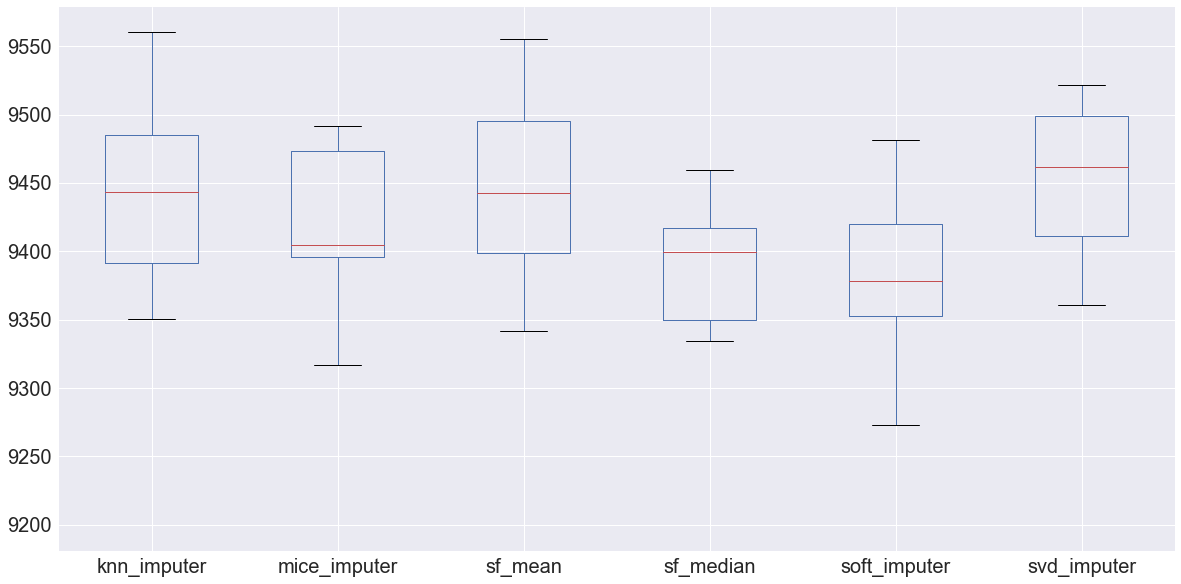

In [327]:
mae_scores_df.plot.box(figsize=(20,10), fontsize=20)

take ten rows from clusters.
append ten rows to train set.
conduct multifit test